In [20]:
import pandas as pd
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib
from matplotlib import pyplot as plt
# import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Read in raw texts

In [2]:
sklepy = open("./sklepy_cynamonowe_polish.txt","r") 
story_text = sklepy.read().split('&&&&&')
story_text.pop(0)

''

In [3]:
book_title = ['Sklepy Cynamonowe'] * 13
story_titles = ['Sierpień','Nawiedzenie','Ptaki','Manekiny','Traktat o Manekinach albo Wtórna Księga Rodzaju',
'Nemrod','Pan','Pan Karol','Sklepy Cynamonowe','Ulica Krokodyli','Karakony','Wichura','Noc Wielkiego Sezonu']
df1 = pd.DataFrame(list(zip(book_title, story_titles, story_text)), columns = ['book', 'story_title', 'text_polish']) 

In [4]:
sanatorium = open("./sanatorium_pod_klepsydra_polish.txt","r") 
story_text = sanatorium.read().split('&&&&&')

In [5]:
book_title = ['Sanatorium Pod Klepysdrą'] * 13
story_titles = ['Księga','Genialna Epoka ','Wiosna','Noc lipcowa','Mój ojciec wstępuje do strażaków',
'Druga jesień','Martwy sezon','Sanatorium pod Klepsydrą','Dodo','Edzio','Emeryt','Samotność',
'Ostatnia ucieczka ojca']
df2 = pd.DataFrame(list(zip(book_title, story_titles, story_text)), columns =['book', 'story_title', 'text_polish']) 

In [6]:
ogdf = pd.concat([df1,df2],ignore_index=True)
df = ogdf

In [7]:
df.head()

,book,story_title,text_polish
0,Sklepy Cynamonowe,Sierpień,\n\nSierpień\n\n1\n\nW lipcu ojciec mój wyjeżd...
1,Sklepy Cynamonowe,Nawiedzenie,\n\nNAWIEDZENIE\n\n1\n\nJuż wówczas miasto nas...
2,Sklepy Cynamonowe,Ptaki,"\n\nPTAKI\n\nNadeszły żółte, pełne nudy dni zi..."
3,Sklepy Cynamonowe,Manekiny,\n\nManekiny\n\nTa ptasia impreza mego ojca by...
4,Sklepy Cynamonowe,Traktat o Manekinach albo Wtórna Księga Rodzaju,\n\nTRAKTAT O MANEKINACH ALBO WTÓRNA KSIĘGA RO...


In [8]:
df.tail()

,book,story_title,text_polish
21,Sanatorium Pod Klepysdrą,Dodo,\n\nPrzychodził do nas w sobotę po południu w ...
22,Sanatorium Pod Klepysdrą,Edzio,"\n\nEDZIO\n\nNa tym samym, co my, piętrze domu..."
23,Sanatorium Pod Klepysdrą,Emeryt,\nEMERYT\n\nJestem emerytem w dosłownym i całk...
24,Sanatorium Pod Klepysdrą,Samotność,\n\nSAMOTNOŚĆ \n\nOd kiedy mogę wychodzić na m...
25,Sanatorium Pod Klepysdrą,Ostatnia ucieczka ojca,\n\nOstatnia ucieczka ojca\n\nByło to w późnym...


### Process data

In [ ]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)

In [ ]:
df['length'] = df['text_polish'].apply(length)

In [9]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [10]:
df['text_polish'] = df['text_polish'].apply(remove_punctuation)

In [12]:
df.text_polish[0]

'\n\nSierpień\n\n1\n\nW lipcu ojciec mój wyjeżdżał do wód i zostawiał mnie z matką i starszym bratem na pastwę białych od żaru i oszołamiających dni letnich Wertowaliśmy odurzeni światłem w tej wielkiej księdze wakacji której wszystkie karty pałały od blasku i miały na dnie słodki do omdlenia miąższ złotych gruszek\n\nAdela wracała w świetliste poranki jak Pomona z ognia dnia rozżagwionego wysypując z koszyka barwną urodę słońca lśniące pełne wody pod przejrzystą skórką czereśnie tajemnicze czarne wiśnie których woń przekraczała to co ziszczało się w smaku morele w których miąższu złotym był rdzeń długich popołudni a obok tej czystej poezji owoców wyładowywała nabrzmiałe siłą i pożywnością płaty mięsa z klawiaturą żeber cielęcych wodorosty jarzyn niby zabite głowonogi i meduzy surowy materiał obiadu o smaku jeszcze nie uformowanym i jałowym wegetatywne i telluryczne ingrediencje obiadu o zapachu dzikim i polnym\n\nPrzez ciemne mieszkanie na pierwszym piętrze kamienicy w rynku przechodz

In [34]:
#nltk.download('stopwords')
sw = stopwords.words('english')
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [43]:
#https://github.com/bieli/stopwords/blob/master/polish.stopwords.txt
stop_words = open("./polish_stopwords.txt","r") 
stop_words = stop_words.readlines()
stop_words = [x.replace('\n', '') for x in stop_words]
stop_words = np.array(stop_words)
stop_words

array(['a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale',
       'alez', 'ależ', 'ani', 'az', 'aż', 'bardziej', 'bardzo', 'beda',
       'bedzie', 'bez', 'deda', 'będą', 'bede', 'będę', 'będzie', 'bo',
       'bowiem', 'by', 'byc', 'być', 'byl', 'byla', 'byli', 'bylo',
       'byly', 'był', 'była', 'było', 'były', 'bynajmniej', 'cala',
       'cali', 'caly', 'cała', 'cały', 'ci', 'cie', 'ciebie', 'cię', 'co',
       'cokolwiek', 'cos', 'coś', 'czasami', 'czasem', 'czemu', 'czy',
       'czyli', 'daleko', 'dla', 'dlaczego', 'dlatego', 'do', 'dobrze',
       'dokad', 'dokąd', 'dosc', 'dość', 'duzo', 'dużo', 'dwa', 'dwaj',
       'dwie', 'dwoje', 'dzis', 'dzisiaj', 'dziś', 'gdy', 'gdyby', 'gdyz',
       'gdyż', 'gdzie', 'gdziekolwiek', 'gdzies', 'gdzieś', 'go', 'i',
       'ich', 'ile', 'im', 'inna', 'inne', 'inny', 'innych', 'iz', 'iż',
       'ja', 'jak', 'jakas', 'jakaś', 'jakby', 'jaki', 'jakichs',
       'jakichś', 'jakie', 'jakis', 'jakiś', 'jakiz', 'jakiż',
       'jakkol

In [36]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    # joining the list of words with space separator
    return " ".join(text)

In [37]:
df['text_polish'] = df['text_polish'].apply(stopwords)

In [42]:
sc_data = df[df['book'] == 'Sklepy Cynamonowe']
spk_data = df[df['book'] == 'Sanatorium Pod Klepysdrą']

#### one story example

In [13]:
df.text_polish[0].lower() #also get rid of numbers!

'\n\nsierpień\n\n1\n\nw lipcu ojciec mój wyjeżdżał do wód i zostawiał mnie z matką i starszym bratem na pastwę białych od żaru i oszołamiających dni letnich wertowaliśmy odurzeni światłem w tej wielkiej księdze wakacji której wszystkie karty pałały od blasku i miały na dnie słodki do omdlenia miąższ złotych gruszek\n\nadela wracała w świetliste poranki jak pomona z ognia dnia rozżagwionego wysypując z koszyka barwną urodę słońca lśniące pełne wody pod przejrzystą skórką czereśnie tajemnicze czarne wiśnie których woń przekraczała to co ziszczało się w smaku morele w których miąższu złotym był rdzeń długich popołudni a obok tej czystej poezji owoców wyładowywała nabrzmiałe siłą i pożywnością płaty mięsa z klawiaturą żeber cielęcych wodorosty jarzyn niby zabite głowonogi i meduzy surowy materiał obiadu o smaku jeszcze nie uformowanym i jałowym wegetatywne i telluryczne ingrediencje obiadu o zapachu dzikim i polnym\n\nprzez ciemne mieszkanie na pierwszym piętrze kamienicy w rynku przechodz

In [15]:
tokens = [t for t in word_tokenize(df.text_polish[0].lower()) if t not in (',', '“', '”', '"','.')]

In [16]:
# (1) lexical_richness
distinct_tokens = set(tokens)
lexical_richness = len(distinct_tokens) / len(tokens)

In [17]:
lexical_richness

0.6420454545454546

In [21]:
freq = FreqDist(tokens)
print(freq.most_common(200))

[('i', 99), ('w', 77), ('się', 59), ('z', 56), ('na', 51), ('jak', 29), ('do', 19), ('od', 14), ('tej', 13), ('o', 13), ('po', 10), ('jakby', 10), ('dnia', 9), ('przez', 9), ('mnie', 8), ('a', 8), ('jego', 8), ('jej', 8), ('pod', 7), ('których', 7), ('był', 7), ('nie', 7), ('że', 7), ('tym', 6), ('twarzy', 6), ('za', 6), ('którym', 6), ('ale', 6), ('żaru', 5), ('której', 5), ('to', 5), ('jeszcze', 5), ('zdawało', 5), ('tych', 5), ('tam', 5), ('dni', 4), ('dzień', 4), ('nad', 4), ('te', 4), ('losu', 4), ('które', 4), ('który', 4), ('bez', 4), ('ogrodu', 4), ('tego', 4), ('twarz', 4), ('była', 4), ('ich', 4), ('matką', 3), ('białych', 3), ('wielkiej', 3), ('wszystkie', 3), ('adela', 3), ('co', 3), ('rynku', 3), ('całe', 3), ('cisza', 3), ('słońcu', 3), ('wszyscy', 3), ('grymas', 3), ('gdyby', 3), ('swym', 3), ('tę', 3), ('maskę', 3), ('nim', 3), ('stare', 3), ('przed', 3), ('było', 3), ('cieniu', 3), ('męża', 3), ('powoli', 3), ('weszliśmy', 3), ('wielka', 3), ('już', 3), ('cicho', 3), (

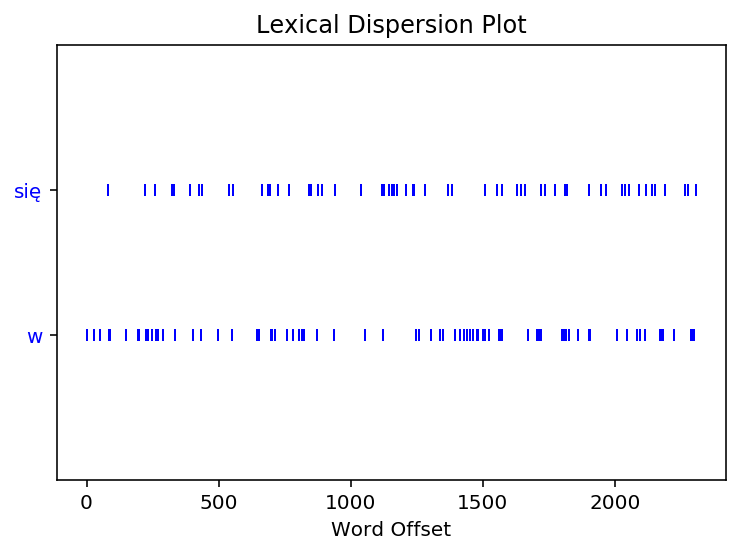

In [138]:
ntext = nltk.Text(tokens)
ntext.dispersion_plot(['się', 'w'])

In [139]:
import random
print(', '.join([w for w in random.sample(freq.hapaxes(), 40)]))

mydłem, podbrzuszu, śniące, zapadnięte, heroizm, skrzypi, podrygi, cięte, drogocenny, malowidła, gospodyniom, płodach, płci, bezwstydnie, domu, faldziste, stopami, krupy, szczerzyli, dawnych, podnoszą, różową, egzotycznych, delikatne, błyszczącym, chłopców, klawiszach, zielono, własnego, płatami, szeroko, pościeli, dźwiga, rozprzęgały, pleśń, zieleń, krzyczy, żółtymi, różowe, falujących


## Lemmatization

In [23]:
polimorf = pd.read_csv('~/Downloads/polimorf_dictionary.tab', sep = '\t')

In [24]:
polimorf.head(10)

,a,a.1,interj,pospolita
0,a,a,qub,pospolita
1,a,a,qub,pospolita
2,a,a,conj,pospolita
3,a,a,prep:nom,pospolita
4,aa,aa,interj,pospolita
5,AA,AA,subst:pl:acc:p1,własna
6,AA,AA,subst:pl:dat:p1,własna
7,AA,AA,subst:pl:gen:p1,własna
8,AA,AA,subst:pl:inst:p1,własna
9,AA,AA,subst:pl:loc:p1,własna


In [25]:
polimorf.shape

(6578141, 4)

In [26]:
polimorf.drop_duplicates(keep = 'first', inplace = True) 

In [27]:
polimorf.shape

(6509933, 4)

In [28]:
polimorf.pospolita.value_counts()

pospolita               6004695
geograficzna              88476
nazwisko                  72178
imię                      47922
własna                    14754
organizacja                3881
określenie dodatkowe        451
osoba                        73
etnonim                      51
wydarzenie                   42
wytwór                       42
Name: pospolita, dtype: int64

In [29]:
tokens = [t for t in word_tokenize(df.text_polish[0].lower()) if t not in (',', '“', '”', '"','.')]

In [30]:
polimorf.rename(columns={"a": "word", "a.1": "lemmat"}, inplace = True)

In [31]:
lemmat_dict = dict(zip(polimorf.word, polimorf.lemmat)) 

In [32]:
new_tokens = []

In [33]:
for token in tokens:
    try:
        new_tokens.append(lemmat_dict[token])
    except:
        new_tokens.append(token)

## Scratch

In [ ]:
tokens = [t for t in word_tokenize(df.text_polish[0].lower()) if t not in (',', '“', '”', '"','.')]

In [47]:
# create a count vectorizer object
count_vectorizer = CountVectorizer()
# fit the count vectorizer using the text data
count_vectorizer.fit(df['text_polish'])
# collect the vocabulary items used in the vectorizer
dictionary = count_vectorizer.vocabulary_.items()  

ValueError: Iterable over raw text documents expected, string object received.

In [45]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_bef_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)

In [46]:
vocab_bef_stem.head(100)

żądało             18780
żądać              18779
żądanie            18778
żądania            18777
żądając            18776
żółwie             18775
żółtą              18774
żółtymi            18773
żółtym             18772
żółtych            18771
żółty              18770
żółtości           18769
żółtej             18768
żółtego            18767
żółte              18766
żółta              18765
żyłą               18764
żyły               18763
żyłki              18762
żyłem              18761
żyłek              18760
żyłach             18759
żyła               18758
żył                18757
żyć                18756
żywą               18755
żywych             18754
żywy               18753
żywotów            18752
żywotność          18751
                   ...  
żubry              18710
żony               18709
żonanieboszczka    18708
żeśmy              18707
żeś                18706
żeru               18705
żelazną            18704
żelaznym           18703
żelaznych          18702


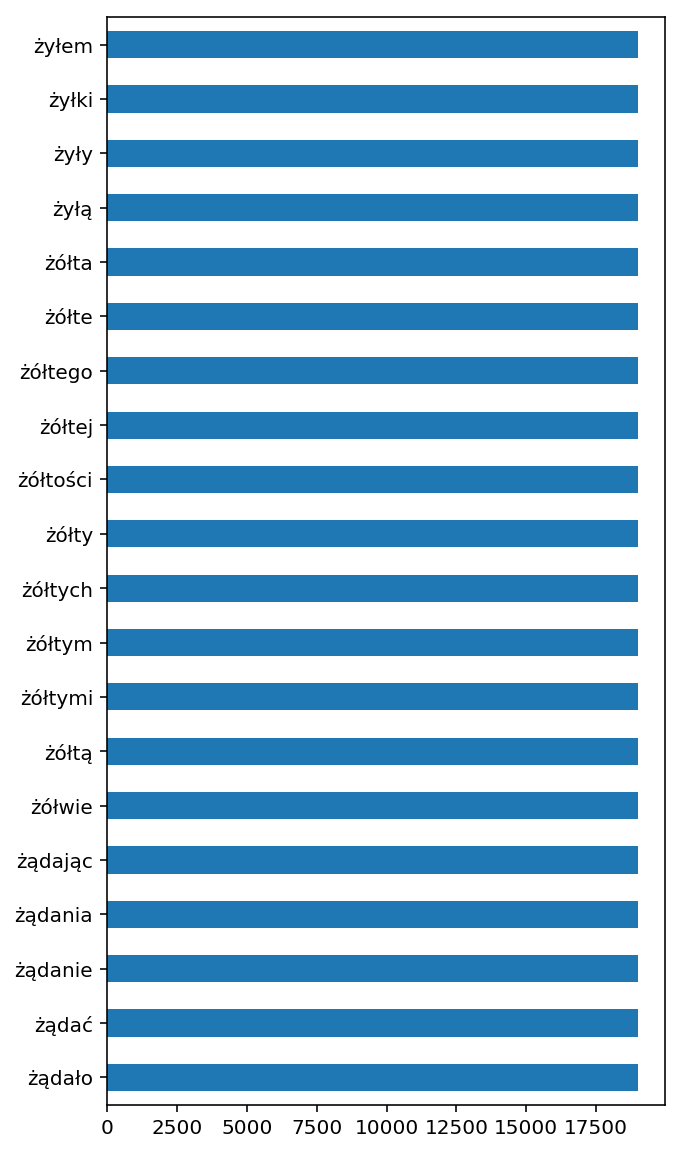

In [93]:
top_vacab = vocab_bef_stem.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10))